<a href="https://colab.research.google.com/github/mark-nick-o/AIML_SoundArtsProject/blob/main/Copy_of_Text2Art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# AttnGAN
#
# Make screen from words example taken from kilchbek haydarov
#
#

In [22]:
!git clone https://github.com/taoxugit/AttnGAN.git

fatal: destination path 'AttnGAN' already exists and is not an empty directory.


In [2]:
!wget text_encoder.pth https://saai-factory-assets.s3.us-west-2.amazonaws.com/attgan/text_encoder.pth
!wget netG_epoch.pth https://saai-factory-assets.s3.us-west-2.amazonaws.com/attgan/netG_epoch_40.pth
!wget captions.pickle https://saai-factory-assets.s3.us-west-2.amazonaws.com/attgan/captions.pickle

--2021-08-09 12:34:48--  http://text_encoder.pth/
Resolving text_encoder.pth (text_encoder.pth)... failed: Name or service not known.
wget: unable to resolve host address ‘text_encoder.pth’
--2021-08-09 12:34:48--  https://saai-factory-assets.s3.us-west-2.amazonaws.com/attgan/text_encoder.pth
Resolving saai-factory-assets.s3.us-west-2.amazonaws.com (saai-factory-assets.s3.us-west-2.amazonaws.com)... 52.92.145.218
Connecting to saai-factory-assets.s3.us-west-2.amazonaws.com (saai-factory-assets.s3.us-west-2.amazonaws.com)|52.92.145.218|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52247233 (50M) [application/x-www-form-urlencoded]
Saving to: ‘text_encoder.pth’

text_encoder.pth    100%[===================>]  49.83M  29.9MB/s    in 1.7s    

2021-08-09 12:34:50 (29.9 MB/s) - ‘text_encoder.pth’ saved [52247233/52247233]

FINISHED --2021-08-09 12:34:50--
Total wall clock time: 2.2s
Downloaded: 1 files, 50M in 1.7s (29.9 MB/s)
--2021-08-09 12:34:50--  http://netg

In [23]:
import sys
import torch
import pickle 
import numpy as np
from PIL import Image
sys.path.append('/content/AttnGAN/code/')

from miscc.config import cfg, cfg_from_file
from model import RNN_ENCODER, G_NET
from torch.autograd import Variable


In [24]:
# load configuration
cfg.GAN.DF_DIM = 96
cfg.GAN.GF_DIM = 48
cfg.GAN.Z_DIM = 100
cfg.GAN.R_NUM = 3
cfg.TEXT.EMBEDDING_DIM = 256
cfg.TRAIN.NET_E = '/content/text_encoder.pth'
cfg.TRAIN.NET_G = '/content/netG_epoch_40.pth'
cfg.CUDA = True

In [26]:
def models(word_len):
  # Load Text Encoder
  text_encoder = RNN_ENCODER(word_len, nhidden=cfg.TEXT.EMBEDDING_DIM)
  state_dict = torch.load(cfg.TRAIN.NET_E, map_location=lambda storage, loc: storage)
  text_encoder.load_state_dict(state_dict)
  if cfg.CUDA:
    text_encoder.cuda()
  text_encoder.eval()

  # Load Generator
  netG = G_NET()
  state_dict = torch.load(cfg.TRAIN.NET_G, map_location=lambda storage, loc: storage)
  netG.load_state_dict(state_dict)
  if cfg.CUDA:
    netG.cuda()
  netG.eval()

  return text_encoder, netG

def word_index():
  with open('/content/captions.pickle', 'rb') as f:
    x = pickle.load(f)
  ixtoword, wordtoix = x[2], x[3]
  
  return wordtoix, ixtoword

def vectorize_caption(wordtoix, caption, copies=2):
    # create caption vector
    tokens = caption.split(' ')
    cap_v = []
    for t in tokens:
        t = t.strip().encode('ascii', 'ignore').decode('ascii')
        if len(t) > 0 and t in wordtoix:
            cap_v.append(wordtoix[t])

    # expected state for single generation
    captions = np.zeros((copies, len(cap_v)))
    for i in range(copies):
        captions[i,:] = np.array(cap_v)
    cap_lens = np.zeros(copies) + len(cap_v)

    return captions.astype(int), cap_lens.astype(int)

def generate(caption, wordtoix, ixtoword, text_encoder, netG , copies=2):
    # load word vector
    captions, cap_lens  = vectorize_caption(wordtoix, caption, copies)
    n_words = len(wordtoix)

    # only one to generate
    batch_size = captions.shape[0]

    nz = cfg.GAN.Z_DIM
    captions = Variable(torch.from_numpy(captions), volatile=True)
    cap_lens = Variable(torch.from_numpy(cap_lens), volatile=True)
    noise = Variable(torch.FloatTensor(batch_size, nz), volatile=True)

    if cfg.CUDA:
        captions = captions.cuda()
        cap_lens = cap_lens.cuda()
        noise = noise.cuda()

    

    #######################################################
    # (1) Extract text embeddings
    #######################################################
    hidden = text_encoder.init_hidden(batch_size)
    words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)
    mask = (captions == 0)
        

    #######################################################
    # (2) Generate fake images
    #######################################################
    noise.data.normal_(0, 1)
    fake_imgs, attention_maps, _, _ = netG(noise, sent_emb, words_embs, mask)

    
    # G attention
    cap_lens_np = cap_lens.cpu().data.numpy()

    generated_imgs = []
    for j in range(batch_size):
      for k in range(len(fake_imgs)):
          im = fake_imgs[k][j].data.cpu().numpy()
          im = (im + 1.0) * 127.5
          im = im.astype(np.uint8)
          im = np.transpose(im, (1, 2, 0))
          im = Image.fromarray(im)
          generated_imgs.append(im)
          
    return generated_imgs

In [27]:
wordtoix, _ = word_index()

# This is where you enter you're own words to make the pictures
# edit is like ..... caption = "what words you use cApitAls make vAriAtiOn"
# and each time you run it is different

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/content/Att

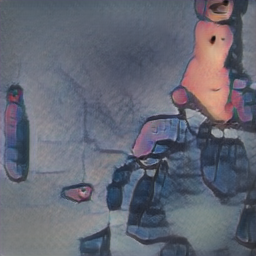

In [79]:
#caption = "womAn and maN are dancing"
#
# maybe this one is more like the decriptions anyway output is funky for video
# 
caption = "boy and Girl daNce to the funky sounds dEEp iNto the night"
# load word dictionaries
wordtoix, ixtoword = word_index()
# load models
text_encoder, netG = models(len(wordtoix))
try:
  generated_imgs = generate(caption, wordtoix, ixtoword, text_encoder, netG)
except:
  print("--------------------- ERROR :: Cant understand sentance (loading the previous image) ------------------------")
generated_imgs[2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/content/AttnGAN/code/GlobalAttention.py:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn = self.sm(attn)  # Eq. (2)


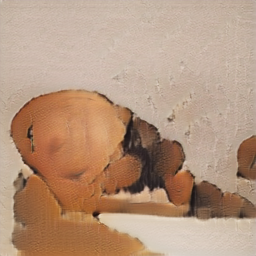

In [81]:
#caption = "woman and man are daNcing with the sLoW biRd spirit"
#caption = "kvinde og mand danSer mEd den langsomme fugl ånd"
#caption = "vrouw en man dansen met de langzame vogel geest"
#caption = "vrouw en man dansen met de langzame vogel geest"
#caption = "žena a muž tančí s pomalým ptačím duchem"
#caption = "menyw a dyn yn dawnsio gyda yn araf adar ysbryd"
#caption = "an spiorad a tha slaodach a ' dannsa leis an t-eun Duine agus bean"
# nearly blank with this one in irish .... caption = "spiorad mall damhsa leis an éan Fear agus bean"
#caption = "kona og maður eru að dansa með hægu og fugl anda"
caption = "gruaja dhe burri po vallëzojnë me shpirtin e ngadaltë të shpendëve"
# ====== cant deal with these alphabets or sentances =========================== 
#caption = "женщина и мужчина танцуют с медленным птичьим духом"
#caption = "女性と男性は遅い鳥の精神で踊っています"
#caption = "naine ja mees tantsivad aeglase linnuvaimuga"
#caption = "הרוח רוקדת סלואו עם איש הציפור והאישה"
#caption = "sieviete un vīrietis dejo ar lēnu putnu garu"
# virtually black in german .... caption = "frau und Mann tanzen mit dem sLoW biRd Spirit"
#
try:
  generated_imgs = generate(caption, wordtoix, ixtoword, text_encoder, netG)
except:
  print("--------------------- ERROR :: Cant understand sentance (loading the previous image) ------------------------")
generated_imgs[2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/content/AttnGAN/code/GlobalAttention.py:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn = self.sm(attn)  # Eq. (2)


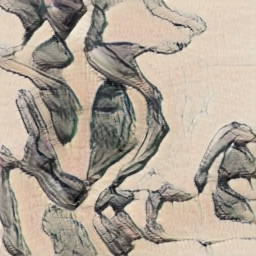

In [82]:
caption = "woman and man are dancing frantically"
try:
  generated_imgs = generate(caption, wordtoix, ixtoword, text_encoder, netG)
except:
  print("--------------------- ERROR :: Cant understand sentance (loading the previous image) ------------------------")  
generated_imgs[2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/content/AttnGAN/code/GlobalAttention.py:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn = self.sm(attn)  # Eq. (2)


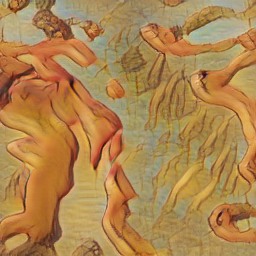

In [83]:
caption = "woman and man are dancing magically"
try:
  generated_imgs = generate(caption, wordtoix, ixtoword, text_encoder, netG)
except:
  print("--------------------- ERROR :: Cant understand sentance (loading the previous image) ------------------------")
generated_imgs[2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/content/AttnGAN/code/GlobalAttention.py:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn = self.sm(attn)  # Eq. (2)


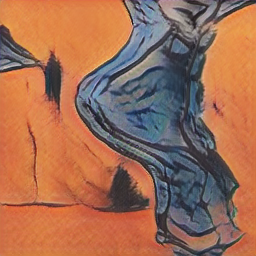

In [84]:
caption = "man an woman fast rythmic pulses in the dance of flared beats"
try:
  generated_imgs = generate(caption, wordtoix, ixtoword, text_encoder, netG)
except:
  print("--------------------- ERROR :: Cant understand sentance (loading the previous image) ------------------------")  
generated_imgs[2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/content/AttnGAN/code/GlobalAttention.py:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn = self.sm(attn)  # Eq. (2)


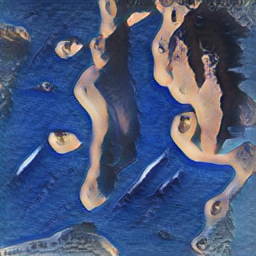

In [90]:
caption = "woman N man are swimming underwater dancing in bubble sea"
try:
  generated_imgs = generate(caption, wordtoix, ixtoword, text_encoder, netG)
except:
  print("--------------------- ERROR :: Cant understand sentance (loading the previous image) ------------------------")  
generated_imgs[2]

In [91]:
# Deep Daze
# credits to https://github.com/lucidrains/deep-daze

In [10]:
# tried all of these but always ran out of memory
# also tried version 1.7.1 and 1.9.0 with cpu instead of cuda

# CUDA 10.2
# !pip install torch==1.7.1
!pip install torch==1.9.0+cu101

# CUDA 10.1
#!pip install torch==1.7.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# CUDA 9.2
!pip install torch==1.7.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

# CPU only
!pip install torch==1.9.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

ERROR: Could not find a version that satisfies the requirement torch==1.9.0+cu101 (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2, 0.4.1, 0.4.1.post2, 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.2.0, 1.3.0, 1.3.1, 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0)
ERROR: No matching distribution found for torch==1.9.0+cu101
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu92/torch-1.7.1%2Bcu92-cp37-cp37m-linux_x86_64.whl (577.3 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cpu
    Uninstalling torch-1.9.0+cpu:
      Successfully uninstalled torch-1.9.0+cpu
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu102 requires torch==1.9.0, but you have torch 1.7.1+cu92 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have t

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cpu/torch-1.9.0%2Bcpu-cp37-cp37m-linux_x86_64.whl (175.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1+cu92
    Uninstalling torch-1.7.1+cu92:
      Successfully uninstalled torch-1.7.1+cu92


In [1]:
!pip install deep-daze --upgrade

Setting jit to False because torch version is not 1.7.1.


/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/autocast_mode.py:120: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


image updated at "./woman_N_man_are_swimming_underwater_dancing_in_bubble_sea.jpg"


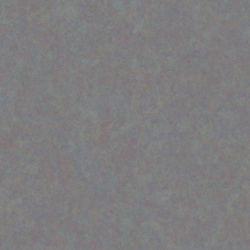

KeyboardInterrupt: ignored

In [1]:
from tqdm.notebook import trange
from IPython.display import Image, display

from deep_daze import Imagine

TEXT = 'woman N man are swimming underwater dancing in bubble sea' #@param {type:"string"}
NUM_LAYERS = 32 #@param {type:"number"}
SAVE_EVERY =  100#@param {type:"number"}
IMAGE_WIDTH = 250 #@param {type:"number"}
SAVE_PROGRESS = True #@param {type:"boolean"}
LEARNING_RATE = 1e-5 #@param {type:"number"}
ITERATIONS = 200 #@param {type:"number"}

model = Imagine(
    text = TEXT,
    num_layers = NUM_LAYERS,
    save_every = SAVE_EVERY,
    image_width = IMAGE_WIDTH,
    lr = LEARNING_RATE,
    iterations = ITERATIONS,
    save_progress = SAVE_PROGRESS
)

for epoch in trange(20, desc = 'epochs'):
    for i in trange(ITERATIONS, desc = 'iteration'):
        model.train_step(epoch, i)

        if i % model.save_every != 0:
            continue

        filename = TEXT.replace(' ', '_')
        image = Image(f'./{filename}.jpg')
        display(image)

In [2]:
# Big Sleep
# credits to https://github.com/lucidrains/deep-daze
!pip install folium==0.2.1
!pip install big-sleep --upgrade

In [3]:
from tqdm.notebook import trange
from IPython.display import Image, display

from big_sleep import Imagine

TEXT = 'woman N man are swimming underwater dancing in bubble sea' #@param {type:"string"}
SAVE_EVERY = 100 #@param {type:"number"}
SAVE_PROGRESS = True #@param {type:"boolean"}
LEARNING_RATE = 5e-2 #@param {type:"number"}
ITERATIONS = 1050 #@param {type:"number"}
SEED = 0 #@param {type: "number"}

model = Imagine(
    text = TEXT,
    save_every = SAVE_EVERY,
    lr = LEARNING_RATE,
    iterations = ITERATIONS,
    save_progress = SAVE_PROGRESS,
    seed = SEED
)

for epoch in trange(20, desc = 'epochs'):
    for i in trange(1000, desc = 'iteration'):
        model.train_step(epoch, i)

        if i == 0 or i % model.save_every != 0:
            continue

        filename = TEXT.replace(' ', '_')
        image = Image(f'./{filename}.png')
        display(image)

AssertionError: ignored